# Austria

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

%config InlineBackend.figure_format = 'retina'

## Fetch results

In [47]:
def get_links_by_letter(letter):
    base_url = 'http://euwahl2014.bmi.gv.at'
    url = f'{base_url}/gemeinden-{letter}.html'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    lis = html.select_one('.gmd-list').select('.nav-link')
    return [f"{base_url}/{x['href']}" for x in lis]

In [48]:
def get_vienna():
    """Special case for Vienna."""
    base_url = 'http://euwahl2014.bmi.gv.at'
    r = requests.get(f'{base_url}/9.html')
    html = BeautifulSoup(r.text)
    select = html.select_one('#qs-district')
    ids = [f"{base_url}/{x.attrs['value']}.html" for x in select.select('option')]
    return ids[1:]

In [49]:
def get_breadcrumbs(text):
    html = BeautifulSoup(text)
    crumbs = html.select_one('.breadcrumbs')
    crumbs = crumbs.select('span')
    return [x.text for x in crumbs]

In [50]:
def get_turnout(text):
    table = pd.read_html(text, header=1, index_col=0, decimal=',')[0]
    turnout = table.loc['Abgegebene', '%']
    return turnout.split('\xa0')[0]

In [51]:
def get_municipality(url):
    r = requests.get(url)
    r.encoding = 'utf-8'
    crumbs = get_breadcrumbs(r.text)
    turnout = get_turnout(r.text)
    return (crumbs, turnout, url)

In [52]:
def run():
    letters = 'abdefghijklmnoprstuvwyz'
    links = []
    data = []
    for letter in letters:
        links.extend(get_links_by_letter(letter))
    links.extend(get_vienna())
    for link in links:
        try:
            data.append(get_municipality(link))
        except requests.exceptions.InvalidSchema:
            print(link)
    return data

In [53]:
def create_frame():
    results = run()
    df = pd.DataFrame(results, columns=['crumbs', 'turnout', 'url'])
    df['turnout'] = df['turnout'].str.replace(',', '.').astype(float)
    df['id'] = df.url.str.split('at\/', expand=True)[1].str.split('\.', expand=True)[0]
    return df

In [54]:
%%time
df = create_frame()

CPU times: user 1min 23s, sys: 2.5 s, total: 1min 25s
Wall time: 12min 6s


In [96]:
# Fix Vienna
df.id = df.id.apply(lambda x: f'{x}01' if len(x) == 3 else x)

In [104]:
df.to_csv('../../data/raw/aut.csv', index=False)

In [9]:
df = pd.read_csv('../../data/raw/aut.csv', dtype={'id': str})

## Merge

In [98]:
geo = gpd.read_file('../../data/shapefiles/aut/STATISTIK_AUSTRIA_GEM_20140101.shp',
                    encoding='utf8')
geo = geo.to_crs(epsg=4326)

In [99]:
geo = geo.merge(df, left_on='ID', right_on='id', how='left')

## Export

In [100]:
geo = geo[['NAME', 'geometry', 'turnout']]

In [101]:
geo.columns = ['name', 'geometry', 'turnout']

In [102]:
geo['country'] = 'aut'

In [122]:
geo.to_file('../../data/processed/aut', encoding='utf8')

## Visualize

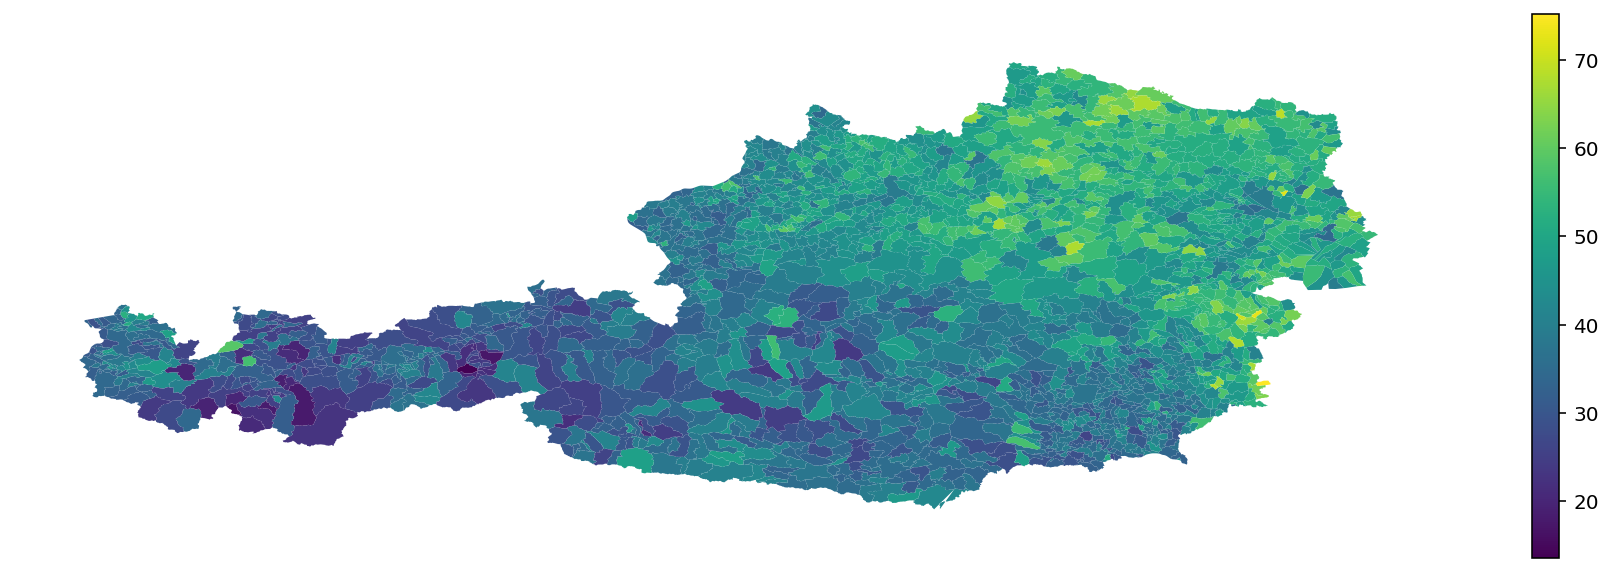

In [121]:
ax = geo.plot(figsize=(16, 5), column='turnout', legend=True);
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/aut_choropleth.png')